In [1]:
import cv2
import os
import numpy as np
from PIL import Image

In [2]:
with open("dataset/Videos/data_test1.rgb", "rb") as f:
    v = np.fromfile(f, np.dtype('B'))
#setting the number of pixels in frame
pxct = 129600
#setting the number of frames
frct = (int)(v.size/(3*pxct))

In [3]:
init_video = []
for frame_number in range(frct):
        start = (frame_number) * pxct * 3
        curr_frame = v[start:start + 3 * pxct]
        final_frame = np.reshape(curr_frame, (480,270,3), order = 'F')
        final_frame = np.rot90(final_frame,3)
        final_frame = np.flip(final_frame,1)
        
        #searching these final frames for logos (new cell)
        init_video.append(final_frame)

In [4]:
#IMAGE RECOGNITION FOR BRANDS




In [5]:
from skimage.metrics import structural_similarity
frame_stats = np.zeros((9000, 2)).tolist()


In [6]:
#save beginning and end of cuts in number of frames
cuts_begin = []
cuts_end = []
#storing the advertisements to replace with
#indexed the same way as that of cuts_begin and cuts_end
#if not to be replaced, a blank line
replaced_advertisements = []

In [7]:
out = cv2.VideoWriter('video.avi', cv2.VideoWriter_fourcc(*'DIVX'), 30, (480, 270))
for i in range(frct - 1):
    out.write(init_video[i])
out.release()

In [8]:
#image negatives for training
# for f in range(frct - 1):
#     if f > 3000 or f < 1200:
#         data = Image.fromarray(init_video[f]).convert('RGB')
#         data.save('negative_images/{}.png'.format(f))

In [9]:
for frame_number in range(frct - 1):
    #calculate new shots with histogram
    #less means more similar
    hist1 = cv2.calcHist([init_video[frame_number]],[0],None,[256],[0,256])
    hist2 = cv2.calcHist([init_video[frame_number + 1]],[0],None,[256],[0,256])
    score=cv2.compareHist(hist1,hist2,cv2.HISTCMP_BHATTACHARYYA)
    
    frame_stats[frame_number][0] = score
    #store score for ssi
    #less means more similar
    #i1 = cv2.cvtColor(init_video[frame_number], cv2.COLOR_BGR2GRAY)
    #i2 = cv2.cvtColor(init_video[frame_number + 1], cv2.COLOR_BGR2GRAY)
    #score2 = structural_similarity(i1, i2)
    #score2 = 1-score2 
    #frame_stats[frame_number][1] = score2
    
    #score indicates sensitivity for shot changes
    if score > 0.3:
        #saves the image, currently used for debugging
        #if score + score2 > 0.3:
        data = Image.fromarray(init_video[frame_number]).convert('RGB')
        data.save('images/{}.png'.format(frame_number))
        data = Image.fromarray(init_video[frame_number+1]).convert('RGB')
        data.save('images/{}.png'.format(frame_number+1))

In [10]:
#reading in all other advertisements
#saves in a dictionary with first part assumed to be the company name
advertisements = {}
PATHS_TO_ADVERTISEMENTS = "dataset/Ads"
for file in os.listdir(PATHS_TO_ADVERTISEMENTS):
    filename = os.fsdecode(file)
    if filename.endswith(".rgb"): 
        vpath = os.path.join(PATHS_TO_ADVERTISEMENTS, filename)
        with open(vpath, "rb") as f:
            v = np.fromfile(f, np.dtype('B'))
        #setting the number of pixels in frame
        pxct = 129600
        #setting the number of frames
        frct = (int)(v.size/(3*pxct))
        video = []
        for frame_number in range(frct):
            start = (frame_number) * pxct * 3
            curr_frame = v[start:start + 3 * pxct]
            final_frame = np.reshape(curr_frame, ( 480,270, 3), order = 'F')
            final_frame = np.rot90(final_frame,3)
            final_frame = np.flip(final_frame,1)
            video.append(final_frame)
        #Get the name of the company
        key = filename.split('_')[0]
        advertisements[key] = video
        
print(advertisements.keys())
    

dict_keys(['Starbucks', 'Subway'])


In [11]:
#splicing in videos with the names 
#save beginning and end of cuts in number of frames
cuts_begin = [2400]
cuts_end = [2849]
#storing the advertisements to replace with
#indexed the same way as that of cuts_begin and cuts_end
#if not to be replaced, an empty string
replaced_advertisements = ["Subway"]
final_video = []
for i in range (len(cuts_begin)):
    if i == 0:
        final_video = init_video[:cuts_begin[i]] + advertisements[replaced_advertisements[i]] + init_video[cuts_end[i]:]
    else:
        #further work required to sync frames iff ad lengths are variable
        final_video = final_video[:cuts_begin[i]] + advertisements[replaced_advertisements[i]] + final_video[cuts_end[i]:]
        

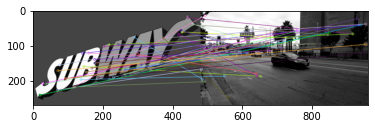

(<matplotlib.image.AxesImage at 0x1be290a30>, None)

In [13]:
#experimenting with SIFT
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


#read in logo 
logo = plt.imread('Dataset/Brand Images/subway_logo.bmp')
graylogo = cv2.cvtColor(logo, cv2.COLOR_BGR2GRAY)
#cv2.imshow('image', graylogo)
#cv2.waitKey(5000)

# #read in frame from video
frame = Image.fromarray(final_video[30]).convert('RGB')

# #reformat
frame.save('images/box-test.png'.format(1));
frame1 = cv2.imread('images/box-test.png')

# #change to grayscale
grayframe = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()

logopoints, logodescriptors = sift.detectAndCompute(graylogo, None)
framepoints, framedescriptors = sift.detectAndCompute(grayframe, None)

bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(logodescriptors,framedescriptors)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(graylogo, logopoints, grayframe, framepoints, matches[:50], grayframe, flags=2)
plt.imshow(img3),plt.show()

# #find keypoints in logo
# siftlogo = cv2.SIFT_create()
# kp = siftlogo.detect(logo, None)
# img = cv2.drawKeypoints(graylogo,kp,logo)
# #plt.imshow(logo)
    
# # #find keypoints in image
# siftframe = cv2.SIFT_create()
# kp = siftframe.detect(frame1, None)
# img = cv2.drawKeypoints(grayframe,kp,frame1)
#plt.imshow(frame1)



In [ ]:
#create the video
#file path, format, frames per second, width and height
out = cv2.VideoWriter('video.avi', cv2.VideoWriter_fourcc(*'DIVX'), 30, (480, 270))
frames = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]    

for i in range(len(final_video)):
    #cv2.imshow('images/box-1.png', img)
    data = Image.fromarray(final_video[i]).convert('RGB')
#print(type(data))

#convert rgb frame to png for writing
    data.save('images/box-test.png'.format(1));

#get new saved png frame
    img = cv2.imread('images/box-test.png')

    if(i in frames):
#draw rectangle on frame
        cv2.rectangle(img, (10,10), (100, 100), (0, 255, 0), 2)
#just to verify box comes out in right spot
        #cv2.imwrite("images/test-box.png", img)

#change back to rgb for avi video
        #img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        out.write(img)
    else:
        out.write(img)

out.release()

In [ ]:
type(img[0][0][0])
